In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
from scipy.optimize import brentq
import sys
import glob
import seaborn as sns
import itertools

# Import the Python machine learning libraries we need

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

plt.rcParams["figure.figsize"] = (10, 6)

#### Likelihood model for BCR

In [33]:
N_h = [201500, 466600, 394100, 428500, 276100, 339200, 345700, 246700, 248900, 158500]
N_c = [8800, 3300, 11400, 7500, 3200, 7100,3200, 1200, 3550, 1950, 3550, 3900, 2900, 1850, 1650, 3700, 3900, 5350, 4750, 2700, 4350, 5650, 9100, 4850, 4500,1000, 19300, 3700, 3600, 7100, 15300, 12100, 2700, 700, 2400, 15400, 400, 4200, 300, 5900, 3600, 13800, 2900, 54900]

In [34]:
file = '/home/ruiz/Sharing/SARS-CoV-2/All_datasets/x>1/total_covid_igg_cdr3aa_vj_shifted.txt'
df = pd.read_csv(file, delimiter='\t')

df2 = df.loc[df['p']<0.0001, :]
df2 = df2.sort_values(by=['p'], ascending=[True])
df2_sub = df2[0:1000]

fInput = 'LR_healthy.txt'
df3 = pd.read_csv(fInput, delimiter='\n', skip_blank_lines=False)

In [35]:
X = np.zeros([40,1000])
for n, x in enumerate(df2_sub['files']):
    files = x.split(',')
    for f in files:
        if np.int(f) < 30:
            X[np.int(f)][n] = 1

for n, x in enumerate(df3['0'][0:1000]):
    if pd.isna(x) == True:
        pass
    else:
        files = x.split(',')
        for f in files:
            #if np.int(f) < 6:
            X[np.int(f)+29][n] = 1

In [36]:
def q_h1(p,n):
    return(p*n)

def p_h1(x, ppost, n):
    sum1 = 0
    sum0 = 0
    for i in range(len(x)):
        if x[i] == 1:
            sum1 += np.log(np.float(q_h1(ppost[i],n)))
        if x[i] == 0:
            sum0 += np.log(np.float(1-q_h1(ppost[i],n)))
    return(sum1 + sum0)

q = 1e-6
ppost = list(df2_sub['ppost']/q)

N = N_c[0:30]+N_h

P_h1 = []
for i in range(len(X)):
    P_h1.append(p_h1(X[i], ppost, N[i]))

In [37]:
def function_for_p(y,x,N):
    sum0 = 0
    N_sum = sum(N)
    for j in range(len(x)):
        prob = np.exp(-(y)*N[j])
        if  x[j]!=0:
            sum0 += (N[j]/(1-prob))
    return(sum0-N_sum)

a = float(1)
b = float(0)

XS = X.transpose()
pdata = []
for (i,x) in enumerate(XS):
    if function_for_p(0,x,N)*function_for_p(1,x,N)<0:
        pdata.append(brentq(function_for_p, a, b, args=(x,N)))
    else:
        sum_xi = sum(x)
        pdata.append(sum_xi/sum(N))

/home/ruiz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


In [38]:
def q_h2(p,n):
    return(1 - np.float(np.exp(-p*n)))

def p_h2(x, pdata, n):
    sum1 = 0
    sum0 = 0
    for i in range(len(x)):
        if x[i] == 1:
            sum1 += np.log(np.float(q_h2(pdata[i],n)))
        if x[i] == 0:
            sum0 += np.log(np.float(1-q_h2(pdata[i],n)))
    return(sum1 + sum0)

P_h2 = []
for i in range(len(X)):
    P_h2.append(p_h2(X[i], pdata, N[i]))

In [39]:
log_p_bcr = []
for x,y in zip(P_h1, P_h2):
    #log_p_bcr.append((x-y)/len(X))
    log_p_bcr.append((y-x)/len(X))

#### Logistic Regression for TCR

In [9]:
file = 'cdr3aa_vj_files_adaptive.txt'
df = pd.read_csv(file, delimiter='\t')

snumber = []
for x in df['files']:
    files = x.split(',')
    snumber.append(len(files))
    
df['snumber'] = snumber 

df2 = df.loc[((df['Posterior_prob']==0.0)|(df['p']<1e-140))&(np.log10(df['ppost_f']/0.452)/np.log10(df['pdata'])>1.1), :]

In [10]:
y = np.zeros([2080])
for i in range(0,1414):
    y[i] = 1
for i in range(1414,2080):
    y[i] = 0

In [11]:
df2_sub = df2.sort_values(by=['snumber'], ascending=[False])[0:7000]

X = np.zeros([2080,7000])
for n, x in enumerate(df2_sub['files']):
    files = x.split(',')
    for f in files:
        X[np.int(f)][n] = 1

for n, x in enumerate(df2_sub['file_in_healthy']):
    files = x.split(',')
    for f in files:
        X[np.int(f)+1414][n] = 1

In [12]:
# Divide covid-19 X part in 10

X1_c = X[0:141]
X2_c = X[141:282]
X3_c = X[282:423]
X4_c = X[423:564]
X5_c = X[564:705]
X6_c = X[705:846]
X7_c = X[846:987]
X8_c = X[987:1128]
X9_c = X[1128:1269]
X10_c = X[1269:1414]

# Divide healthy X part in 10

X1_h = X[1414:1480]
X2_h = X[1480:1546]
X3_h = X[1546:1612]
X4_h = X[1612:1678]
X5_h = X[1678:1744]
X6_h = X[1744:1810]
X7_h = X[1810:1876]
X8_h = X[1876:1942]
X9_h = X[1942:2008]
X10_h = X[2008:2080]

# Divide covid-19 y part in 10

y1_c = y[0:141]
y2_c = y[141:282]
y3_c = y[282:423]
y4_c = y[423:564]
y5_c = y[564:705]
y6_c = y[705:846]
y7_c = y[846:987]
y8_c = y[987:1128]
y9_c = y[1128:1269]
y10_c = y[1269:1414]

# Divide healthy y part in 10

y1_h = y[1414:1480]
y2_h = y[1480:1546]
y3_h = y[1546:1612]
y4_h = y[1612:1678]
y5_h = y[1678:1744]
y6_h = y[1744:1810]
y7_h = y[1810:1876]
y8_h = y[1876:1942]
y9_h = y[1942:2008]
y10_h = y[2008:2080]

In [13]:
y_true = []
y_model = []

prob = []

for i in range(0,10):
    
    # Define all the blocks
    
    all_X_c = [X1_c, X2_c, X3_c, X4_c, X5_c, X6_c, X7_c, X8_c,X9_c, X10_c]
    all_X_h = [X1_h, X2_h, X3_h, X4_h, X5_h, X6_h, X7_h, X8_h,X9_h, X10_h]
    all_y_c = [y1_c, y2_c, y3_c, y4_c, y5_c, y6_c, y7_c, y8_c,y9_c, y10_c]
    all_y_h = [y1_h, y2_h, y3_h, y4_h, y5_h, y6_h, y7_h, y8_h,y9_h, y10_h]

    # Dynamically remove one of the blocks (left for testing)
    
    X_test_covid = all_X_c.pop(i)
    X_test_healthy = all_X_h.pop(i)
    X_test = np.concatenate([X_test_covid,X_test_healthy])
    
    y_test_covid = all_y_c.pop(i)
    y_test_healthy = all_y_h.pop(i)
    y_test = np.concatenate([y_test_covid,y_test_healthy])
    
    y_true.append(y_test) # Save the real test for later
    
    # Train model in the remaining 9 blocks 
    
    X_covid = np.concatenate(all_X_c)
    X_healthy = np.concatenate(all_X_h)
    X_train = np.concatenate([X_covid,X_healthy])
    
    y_covid = np.concatenate(all_y_c)
    y_healthy = np.concatenate(all_y_h)
    y_train = np.concatenate([y_covid,y_healthy])
    
    # Infer the model
    
    model_lr = LogisticRegression(solver='lbfgs',penalty='l2', max_iter=600,class_weight='balanced', C=0.0005)
    
    model_lr.fit(X_train, y_train)
    
    y_model.append(model_lr.predict(X_test))
    
    prob.append(model_lr.predict_proba(X_test)[::,1])

In [14]:
all_y_true = list(itertools.chain.from_iterable(y_true))
all_y_model = list(itertools.chain.from_iterable(y_model))
all_prob = list(itertools.chain.from_iterable(prob))

In [16]:
diagnostic = []
for i in all_y_true:
    if i == 1:
        diagnostic.append('Positive')
    if i == 0:
        diagnostic.append('Negative')

df_prob = pd.DataFrame(list(zip(all_prob, diagnostic)), columns =['Probability', 'Diagnostic'])

### Likelihood Model for TCR

In [15]:
N_h = [109800, 103100, 169300, 205600, 109600, 214500, 181800, 79900, 303500, 97400, 107000, 157900, 211900, 338200, 307400, 257100, 276100, 142400, 334200, 103100, 161900, 143300, 337200, 182100, 228700, 327100, 321000, 306500, 276700, 190500, 185800, 340300,240700, 130500, 353700, 271000, 271600, 317300, 265900, 211300,61800, 198800, 192400, 257100, 151500, 130500, 218300, 195700, 86000,269400, 103000, 179900, 207000, 189700, 288700, 163000, 171900,348400, 271000, 289500, 234700, 210600, 149700, 119200, 170800,184500, 275700, 179300, 218700, 98600, 45200, 157600, 109500, 185400,216900, 62500, 168800, 188500, 227300, 297500, 216200, 201600,134700, 52900, 259500, 170600, 216400, 297600, 208300, 227500,332400, 467500, 311500, 229400, 151800, 91600, 303500, 106400,153700, 115900, 239700, 231300, 332400, 44100, 474900, 221300,229900, 69600, 279600, 169400, 365000, 215200, 132100, 267800,214700, 64700, 183600, 247100, 44200, 120300, 198400, 127500, 322900,239800, 326700, 233700, 318300, 211900, 155500, 138400, 148100,131500, 243000, 240500, 322100, 135000, 219600, 81900, 324800,274100, 182600, 179000, 183600, 251100, 329300, 112800, 86900,308900, 143500, 163300, 176900, 253600, 188100, 281700, 365000,104500, 161400, 203500, 294300, 197700, 275700, 157400, 116200,143500, 157600, 305600, 177800, 296500, 358700, 232200, 277200,222100, 251800, 278800, 279700, 30000, 113100, 132400, 185400,243000, 277400, 235800, 263200, 322800, 191800, 285600, 345000,154600, 95400, 61300, 74600, 271000, 253900, 212500, 167800, 266800,293000, 166600, 131500, 261500, 266200, 67900, 86200, 113300, 94100,1200, 150800, 231900, 108300, 283700, 264000, 79400, 230500, 287200,124600, 269400, 194700, 373700, 302800, 152300, 181800, 203500,366900, 208300, 138900, 216400, 255000, 347200, 349700, 248800,224200, 384700, 366400, 246800, 338200, 99700, 319600, 280500,223600, 167900, 246800, 177900, 271000, 444300, 201100, 98600,138300, 302800, 195500, 169200, 308900, 217200, 345000, 350800,164400, 240500, 218300, 334200, 120500, 229300, 177800, 310700,133200, 298300, 167700, 224800, 187100, 112400, 167500, 237400,280500, 208300, 282600, 167200, 279600, 64400, 200000, 322100,126500, 98600, 154100, 325600, 263200, 119700, 375600, 215900,296500, 72800, 216200, 195900, 252600, 289000, 199100, 265000, 80300,245300, 197600, 156000, 239800, 222800, 254100, 67100, 306400,199200, 163900, 143900, 172800, 153700, 278000, 84500, 111600,235600, 228700, 218600, 388600, 293500, 274100, 256600, 228800,245300, 204700, 116400, 130500, 264000, 124600, 105900, 106800,223500, 274000, 276100, 408900, 303500, 133200, 216900, 213500,199500, 150800, 220900, 94100, 186500, 266800, 125700, 269800,208800, 105800, 223500, 235300, 353200, 231000, 340900, 194700,176900, 310300, 176900, 244200, 234200, 60600, 115200, 96400, 163500,252600, 155800, 114200, 112800, 292200, 61400, 229900, 200300,173200, 147000, 218300, 190000, 162600, 366300, 338200, 205100,116800, 296500, 237400, 123000, 245300, 190200, 371400, 194200,137600, 110800, 291400, 353200, 210700, 282600, 324900, 198200,182100, 213300, 242400, 350800, 217100, 349500, 59400, 165000,484400, 163900, 300900, 61100, 341000, 144100, 210800, 192500, 37000,251100, 281300, 140000, 147500, 203500, 214700, 241900, 193600,112000, 185400, 463800, 273100, 313800, 185900, 294200, 165000,224000, 176500, 104200, 276400, 88500, 262700, 295800, 239200,138900, 157900, 327500, 124400, 243000, 251200, 7200, 263200, 281300,82000, 285300, 55800, 208300, 167200, 164400, 137000, 215000, 233700,78100, 401900, 190200, 185600, 197000, 384700, 38800, 238900, 134300,98300, 64500, 73200, 136300, 184800, 251800, 166100, 127500, 152500,71900, 102700, 177800, 383800, 53200, 296200, 79000, 145300, 185400,108300, 140800, 172800, 95400, 222000, 211200, 230100, 330300, 63900,143300, 200600, 171300, 289900, 114100, 147500, 210800, 25700,401800, 256200, 245300, 208800, 120000, 174900, 124800, 226400,260100, 33500, 72100, 171700, 150200, 346500, 292200, 208800, 267200,143700, 59300, 230500, 231900, 194200, 107400, 308000, 132800,233300, 181200, 192600, 175200, 219100, 120500, 128600, 89800,169200, 231900, 483300, 223600, 61100, 165500, 241100, 140100,212500, 255000, 190700, 317800, 54500, 125400, 200000, 274300,220200, 186400, 163000, 345000, 226700, 195500, 241100, 205400,342300, 183200, 293400, 139600, 276400, 147000, 92100, 119100,325200, 243000, 342900, 92400, 201600, 97000, 216900, 308000, 136400,235500, 11800, 79900, 339200, 16300, 94400, 311500, 216300, 304400,157400, 304600, 231000, 176900, 218300, 213700, 175700, 178300,75500, 202600, 68400, 228700, 119200, 267400, 172800, 257400, 91000,271700, 303600, 278400, 164900, 162600, 281700, 69000, 134800,206400, 284000, 420300, 153300, 153700, 189700, 267200, 142100,203500, 222000, 247300, 238200, 284200, 226400, 125700, 163900,286300, 179900, 218400, 165200, 110900, 98600, 297600, 262700,144700, 292900, 161300, 131800, 238900, 372400, 100000, 210600,147300, 286300, 277100, 75000, 141200, 195200, 228800, 325200, 60400,303800, 282300, 246800, 246800, 283700, 235300, 290100, 239000,327500, 201600, 214300, 211500, 121700, 195200, 235300, 239700,224000, 207000, 55600, 69200, 106100, 291000]

fInput = 'inferred_n.txt'
df = pd.read_csv(fInput, delimiter='\t')
N_c = list(df['Inferred_N'])

In [17]:
df2_sub = df2.sort_values(by=['snumber'], ascending=[False])[:1200]

X = np.zeros([1000,1200])
for n, x in enumerate(df2_sub['files']):
    files = x.split(',')
    for f in files:
        if np.int(f)<700:
            X[np.int(f)][n] = 1

for n, x in enumerate(df2_sub['file_in_healthy']):
    files = x.split(',')
    for f in files:
        if np.int(f)<300:
            X[np.int(f)+700][n] = 1

In [18]:
y_true = np.zeros([1000])
for i in range(0,700):
    y_true[i] = 1
for i in range(700,1000):
    y_true[i] = 0

In [19]:
def q_h1(p,n):
    q = 1 - np.float(np.exp(-p*n))
    if q != 0:
        return(q)
    else:
        q = p*n
        return(q)
    
def p_h1(x, ppost, n):
    sum1 = 0
    sum0 = 0
    for i in range(len(x)):
        if x[i] == 1:
            sum1 += np.log(q_h1(ppost[i],n))
        if x[i] == 0:
            sum0 += np.log(1-q_h1(ppost[i],n))
    return(sum1 + sum0)

In [20]:
q = 0.472
ppost = list(df2_sub['ppost_f']/q)
P_h1 = []
N = N_c[:700] + N_h[:300]

for i in range(len(X)):
    P_h1.append(p_h1(X[i], ppost, N[i]))

In [21]:
def function_for_p(x,y,N):
    sum0 = 0
    N_sum = sum(N)
    for j in range(len(x)):
        prob = np.exp(-(y)*N[j])
        if  x[j]!=0:
            sum0 += (N[j]/(1-prob))
    return(sum0-N_sum)

def solve_for_p(i,x):
    def onevarfunc(y):
        return(function_for_p(x,y,N))

    if onevarfunc(a)*onevarfunc(b)<0:
        return(i,brentq(onevarfunc, a, b)) 
    else:
        sum_xi = sum(x)
        return(i, sum_xi/sum(N_train))
    
def xs2ps(xs):
    pool = mp.Pool(mp.cpu_count())

    results = [pool.apply_async(solve_for_p, args=(i,x)) for (i,x) in enumerate(xs)] 

    results_not_in_order = []

    for res in tqdm(results):
        results_not_in_order.append(res.get(timeout=180))

    ps = np.zeros(len(xs))
    for i,p in results_not_in_order:
        ps[i] = p

    pool.close()

    return ps

In [22]:
a = float(1)
b = float(0)
XS = X.transpose()
pdata = xs2ps(XS)

/home/ruiz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/home/ruiz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/home/ruiz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/home/ruiz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/home/ruiz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/home/ruiz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/home/ruiz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero 

In [23]:
def q_h2(p,n):
    return(1 - np.float(np.exp(-p*n)))

def p_h2(x, pdata, n):
    sum1 = 0
    sum0 = 0
    for i in range(len(x)):
        if x[i] == 1:
            sum1 += np.log(np.float(q_h2(pdata[i],n)))
        if x[i] == 0:
            sum0 += np.log(1-np.float(q_h2(pdata[i],n)))
    return(sum1 + sum0)

In [24]:
P_h2 = []
for i in range(len(X)):
    P_h2.append(p_h2(X[i], pdata, N[i]))

In [25]:
log_p = []
for x,y in zip(P_h1, P_h2):
    log_p.append((x-y)/len(X))

In [26]:
score_llr = log_p


fpr_llr = []

tpr_llr = []

threshold = np.linspace(-2,0, 10000)

# get number of positive and negative examples in the dataset
P = sum(y_true)
N = len(y_true) - P

# iterate through all thresholds and determine fraction of true positives
# and false positives found at this threshold
for thresh1 in threshold:
    FP=0
    TP=0
    for i in range(len(score_llr)):
        if (score_llr[i] > thresh1):
            if y_true[i] == 1:
                TP = TP + 1
            if y_true[i] == 0:
                FP = FP + 1
    fpr_llr.append(FP/float(N))
    tpr_llr.append(TP/float(P))


#### AUC Curve

In [27]:
fpr, tpr, _ = metrics.roc_curve(all_y_true,  all_prob)
auc_lr = metrics.roc_auc_score(all_y_true,  all_prob)
auc_llr = auc(fpr_llr, tpr_llr)

#### All plots

In [28]:
font={'size': 10, 'weight': 'normal', 'family': 'DejaVu Sans'}
plt.rc('text', usetex=True)
plt.rc('font', **font)

No handles with labels found to put in legend.


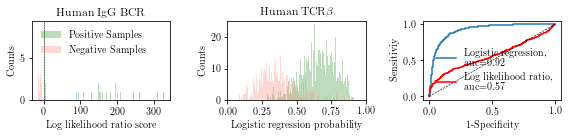

In [48]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(8,2))
plt.rc('text', usetex=True)

#Subplot 1

x1 = log_p_bcr[0:30] # positive sample 
x2 = log_p_bcr[30:] # negative sample

kwargs = dict(histtype='stepfilled', alpha=0.3, density=False, bins=120, label='Positive Samples')
ax1.hist(x1, **kwargs, color='forestgreen')

kwargs = dict(histtype='stepfilled', alpha=0.3, density=False, bins=5,label='Negative Samples')
ax1.hist(x2, **kwargs, color='salmon')

ax1.axvline(0.1,ls='--', lw=0.5, color='black')


ax1.set_title("Human IgG BCR")
ax1.legend(loc='upper left',frameon=False)
ax1.set_xlabel('Log likelihood ratio score')
ax1.set_ylabel('Counts')

# Subplot 2

x1 = df_prob.loc[df_prob['Diagnostic']=='Positive',['Probability']] # positive sample 
x2 = df_prob.loc[df_prob['Diagnostic']=='Negative',['Probability']] # negative sample

kwargs = dict(histtype='stepfilled', alpha=0.3, density=False, bins=200)
ax2.hist(x1['Probability'], **kwargs, color='forestgreen')

kwargs = dict(histtype='stepfilled', alpha=0.3, density=False, bins=200)
ax2.hist(x2['Probability'], **kwargs, color='salmon')


#ax2.title("TCR")
ax2.legend(loc='upper left',frameon=False)
ax2.set_xlabel('Logistic regression probability')
ax2.set_ylabel('Counts')
ax2.set_title(r"Human TCR$\beta$")
ax2.set_xlim(0,1)

# Subplot 3

ax3.plot(fpr,tpr,label="Logistic regression, \n auc=0.92")
ax3.plot(fpr_llr,tpr_llr, color = 'red', label='Log likelihood ratio, \n auc=0.57')
xs = np.arange(0,1.1,0.1)
ax3.plot(xs, xs, ls='--', lw=0.6, c='black')
ax3.set_xlabel('1-Specificity')
ax3.set_ylabel('Sensitiviy')
ax3.legend(loc=4, frameon=False)

plt.tight_layout()

fig.savefig('/home/ruiz/Figure6.pdf',bbox_inches='tight')

plt.show()